In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from dataset_build.clf_dtSet_hugo import build_purity_classification_dataset

In [2]:
N_SHOTS = 1000

df, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
)

# Pauli matrices
SIGMA_X = np.array([[0, 1],[1, 0]], dtype=complex)
SIGMA_Y = np.array([[0, -1j],[1j, 0]], dtype=complex)
SIGMA_Z = np.array([[1, 0],[0, -1]], dtype=complex)

df.head()

,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity
0,-0.876,0.252,-0.450,-0.867564,0.213633,-0.449104,2.036559,2.900152,-0.867564,0.213633,-0.449104,1.000000,True,1
1,0.384,-0.816,-0.374,0.394288,-0.830872,-0.392668,1.974327,5.155468,0.394288,-0.830872,-0.392668,1.000000,True,1
2,0.262,0.140,-0.166,0.231470,0.169346,-0.188555,1.899744,0.348085,0.889626,0.322810,-0.323048,0.343234,False,0
3,-0.104,-0.412,-0.304,-0.083890,-0.409009,-0.328740,2.350699,4.475692,-0.166720,-0.691158,-0.703210,0.531409,False,0
4,0.092,0.402,0.062,0.103858,0.314526,0.079730,1.408067,1.086675,0.459282,0.873391,0.162012,0.340691,False,0


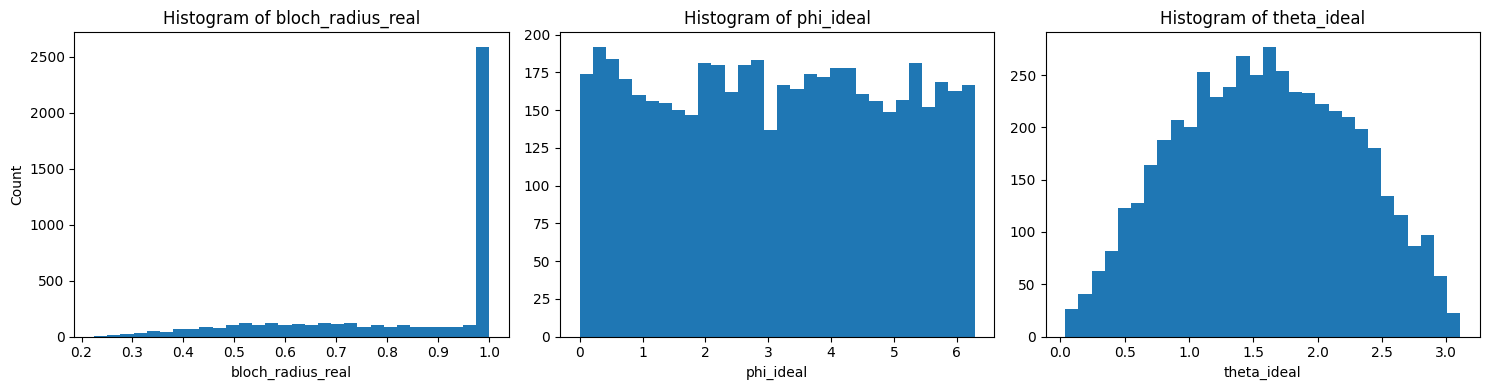

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["bloch_radius_real"], bins=30)
axes[0].set_title("Histogram of bloch_radius_real")
axes[0].set_xlabel("bloch_radius_real")
axes[0].set_ylabel("Count")

axes[1].hist(df["phi_ideal"], bins=30)
axes[1].set_title("Histogram of phi_ideal")
axes[1].set_xlabel("phi_ideal")

axes[2].hist(df["theta_ideal"], bins=30)
axes[2].set_title("Histogram of theta_ideal")
axes[2].set_xlabel("theta_ideal")

plt.tight_layout()
plt.show()

In [5]:
def rho_from_cholesky(params):
    """
    params = [a, b, c, d] real
    T = [[a, 0],
         [b+ic, d]]
    rho = T T^\dagger / Tr(T T^\dagger)
    """
    a, b, c, d = params
    T = np.array([[a, 0.0],
                  [b + 1j*c, d]], dtype=complex)
    X = T @ T.conj().T
    tr = np.trace(X).real
    # Avoid division by 0 in pathological optimizer steps
    if tr <= 0:
        return np.eye(2, dtype=complex) / 2.0
    return X / tr

def bloch_expectations(rho):
    ex = np.trace(rho @ SIGMA_X).real
    ey = np.trace(rho @ SIGMA_Y).real
    ez = np.trace(rho @ SIGMA_Z).real
    return np.array([ex, ey, ez])

def means_to_counts(m, N):
    # m in [-1,1] -> n_plus in [0,N]
    n_plus = int(np.rint(N * (1.0 + float(m)) / 2.0))
    n_plus = int(np.clip(n_plus, 0, N))
    return n_plus, N - n_plus

def nll_from_means(params, X_mean, Y_mean, Z_mean, N, eps=1e-12):
    rho = rho_from_cholesky(params)
    ex, ey, ez = bloch_expectations(rho)

    # Model probabilities
    pX = 0.5 * (1.0 + ex)
    pY = 0.5 * (1.0 + ey)
    pZ = 0.5 * (1.0 + ez)

    # Clip to keep logs finite
    pX = np.clip(pX, eps, 1.0 - eps)
    pY = np.clip(pY, eps, 1.0 - eps)
    pZ = np.clip(pZ, eps, 1.0 - eps)

    # Convert empirical means to counts (binomial)
    nXp, nXm = means_to_counts(X_mean, N)
    nYp, nYm = means_to_counts(Y_mean, N)
    nZp, nZm = means_to_counts(Z_mean, N)

    # Negative log-likelihood
    nll = -(nXp*np.log(pX) + nXm*np.log(1.0 - pX)
            + nYp*np.log(pY) + nYm*np.log(1.0 - pY)
            + nZp*np.log(pZ) + nZm*np.log(1.0 - pZ))
    return float(nll)

def mle_qst_from_row(X_mean, Y_mean, Z_mean, N, x0=None):
    # Sensible init: maximally mixed
    if x0 is None:
        x0 = np.array([1.0, 0.0, 0.0, 1.0], dtype=float)

    res = minimize(
        nll_from_means,
        x0=x0,
        args=(X_mean, Y_mean, Z_mean, N),
        method="L-BFGS-B"
    )
    rho_hat = rho_from_cholesky(res.x)
    return rho_hat, res

In [6]:
rhos = []
success = []
nlls = []

for _, row in df.iterrows():
    rho_hat, res = mle_qst_from_row(row["X_mean"], row["Y_mean"], row["Z_mean"], N=N_SHOTS)
    rhos.append(rho_hat)
    success.append(res.success)
    nlls.append(res.fun)

df["mle_success"] = success
df["mle_nll"] = nlls

In [7]:
df.head(
)

,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity,mle_success,mle_nll
0,-0.876,0.252,-0.450,-0.867564,0.213633,-0.449104,2.036559,2.900152,-0.867564,0.213633,-0.449104,1.000000,True,1,True,1482.002842
1,0.384,-0.816,-0.374,0.394288,-0.830872,-0.392668,1.974327,5.155468,0.394288,-0.830872,-0.392668,1.000000,True,1,True,1546.111920
2,0.262,0.140,-0.166,0.231470,0.169346,-0.188555,1.899744,0.348085,0.889626,0.322810,-0.323048,0.343234,False,0,True,2021.041426
3,-0.104,-0.412,-0.304,-0.083890,-0.409009,-0.328740,2.350699,4.475692,-0.166720,-0.691158,-0.703210,0.531409,False,0,True,1939.623621
4,0.092,0.402,0.062,0.103858,0.314526,0.079730,1.408067,1.086675,0.459282,0.873391,0.162012,0.340691,False,0,True,1990.147759


In [8]:
def qubit_fidelity_from_bloch(r_est, r_true):
    """Fidelity F(r_est, r_true) for 1-qubit states."""
    r_est = np.asarray(r_est, dtype=float)
    r_true = np.asarray(r_true, dtype=float)

    re2  = np.dot(r_est, r_est)
    rt2  = np.dot(r_true, r_true)
    dot  = np.dot(r_est, r_true)

    # Formula for qubit density matrices
    rad_term = (1.0 - re2) * (1.0 - rt2)
    rad_term = max(0.0, rad_term)        # avoid tiny negatives
    F = 0.5 * (1.0 + dot + np.sqrt(rad_term))
    return float(np.clip(F, 0.0, 1.0))

def bloch_from_rho(rho):
    """Return Bloch vector (rx, ry, rz) from a 2x2 density matrix."""
    rx = np.trace(rho @ SIGMA_X).real
    ry = np.trace(rho @ SIGMA_Y).real
    rz = np.trace(rho @ SIGMA_Z).real
    return np.array([rx, ry, rz], dtype=float)

In [9]:
fids = []

for (rho_hat, (_, row)) in zip(rhos, df.iterrows()):
    # Estimated Bloch vector from MLE state
    r_est = bloch_from_rho(rho_hat)

    # True Bloch vector (from dataset)
    r_true = np.array([row["X_real"], row["Y_real"], row["Z_real"]], dtype=float)

    F = qubit_fidelity_from_bloch(r_est, r_true)
    fids.append(F)

df["fidelity_mle"] = fids

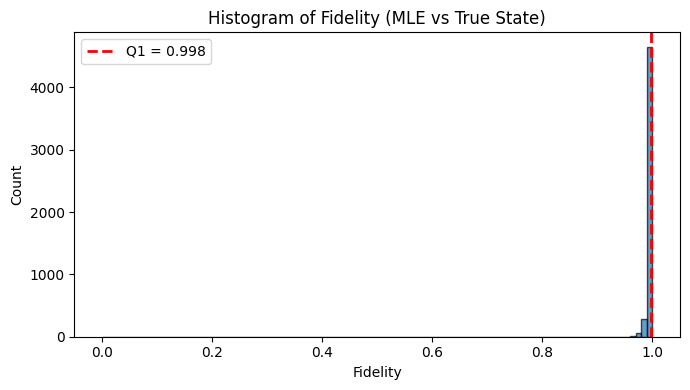

In [10]:
# Extract fidelity values
fids = df["fidelity_mle"].to_numpy()

# Compute Q1 (first quartile = 25% quantile)
q1 = np.quantile(fids, 0.25)

# Plot histogram
plt.figure(figsize=(7,4))
plt.hist(fids, bins=100, range=(0,1), edgecolor='black', alpha=0.7)

# Add vertical line for Q1
plt.axvline(q1, color='red', linestyle='--', linewidth=2, label=f"Q1 = {q1:.3f}")

plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Histogram of Fidelity (MLE vs True State)")
plt.legend()
plt.tight_layout()
plt.show()

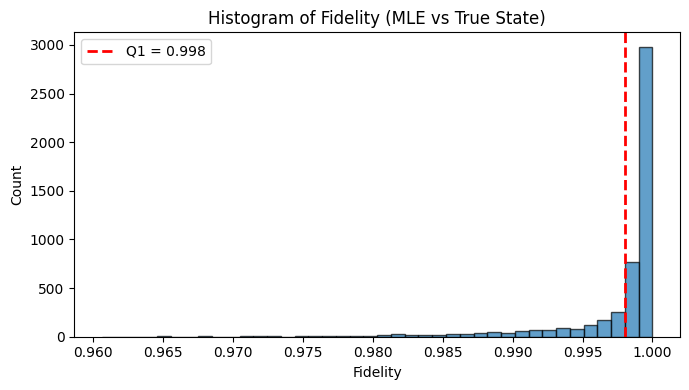

In [11]:
# Extract fidelity values
fids = df["fidelity_mle"].to_numpy()

# Compute Q1 (first quartile = 25% quantile)
q1 = np.quantile(fids, 0.25)

# Plot histogram
plt.figure(figsize=(7,4))
plt.hist(fids, bins=40, edgecolor='black', alpha=0.7)

# Add vertical line for Q1
plt.axvline(q1, color='red', linestyle='--', linewidth=2, label=f"Q1 = {q1:.3f}")

plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Histogram of Fidelity (MLE vs True State)")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
!jupyter nbconvert --to html MLE.ipynb

[NbConvertApp] Converting notebook MLE.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 401770 bytes to MLE.html
